# Exploratory Data Analysis
This notebook aims to explore the dataset to gain additional insights.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -qqq emoji fasttext

     |████████████████████████████████| 216 kB 8.2 MB/s 
     |████████████████████████████████| 68 kB 5.9 MB/s 


In [ ]:
# Import packages
import os
import pandas as pd
import numpy as np
import itertools
import collections
import networkx as nx
import six
import matplotlib.pyplot as plt
import seaborn as sns
import emoji as em
import fasttext

from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split

import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Change to your own directory
try: 
    os.chdir("/content/drive/MyDrive/Suicide Project")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [ ]:
# Set constants
SEED = 4222

## Original Dataset

In [ ]:
# Load dataset
df = pd.read_csv('Data/Suicide_Detection.csv', index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
# Check for null values
df.isnull().sum()

text     0
class    0
dtype: int64

suicide        116037
non-suicide    116037
Name: class, dtype: int64
suicide        0.5
non-suicide    0.5
Name: class, dtype: float64


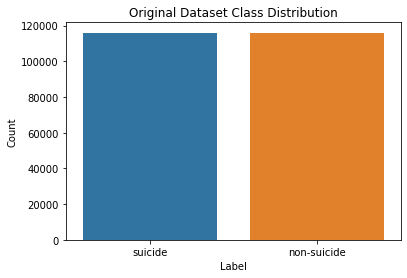

In [ ]:
# Check class distribution
print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))

sns.countplot(x=df['class'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [ ]:
# Check lowercase
lowercase = df['text'].str.islower()
print(lowercase.value_counts())

# df['text'][lowercase == True]

False    214395
True      17679
Name: text, dtype: int64


In [ ]:
# Check extra whitespace
extra_whitespace = df['text'].str.match('\s\s+')
print(extra_whitespace.value_counts())

# df['text'][extra_whitespace == True]

False    232073
True          1
Name: text, dtype: int64


In [ ]:
# Check URL
url = df['text'].str.contains("http")
print(url.value_counts())

# df['text'][url == True]

False    224921
True       7153
Name: text, dtype: int64


In [ ]:
# Check mentions
mention = df['text'].str.match('@(\w+)')
print(mention.value_counts())

# df['text'][mention == True]

False    232072
True          2
Name: text, dtype: int64


In [ ]:
# Check hashtags
hashtag = df['text'].str.match('#(\w+)')
print(hashtag.value_counts())

# df['text'][hashtag == True]

False    232061
True         13
Name: text, dtype: int64


In [ ]:
# Check subreddit tag
subreddit = df['text'].str.match('r/(\w+)')
print(subreddit.value_counts())

# df['text'][subreddit == True]

False    231990
True         84
Name: text, dtype: int64


In [ ]:
# Check users tag
users = df['text'].str.match('u/(\w+)')
print(users.value_counts())

# df['text'][users == True]

False    231859
True        215
Name: text, dtype: int64


In [ ]:
# Check special characters
special_characters = df['text'].str.match('[^0-9a-zA-Z]+')
print(special_characters.value_counts())

# df['text'][special_characters == True]

False    229638
True       2436
Name: text, dtype: int64


In [ ]:
! pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import emoji

# Check emojis
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

emoji = df['text'].apply(text_has_emoji)
print(emoji.value_counts())

# df['text'][emoji == True]

AttributeError: ignored

In [ ]:
def count_emojis(text):
    return len([c for c in text if c in em.UNICODE_EMOJI['en'].keys()])

emoji = df['text'].apply(count_emojis)
print(emoji.value_counts())

# df['text'][emoji > 0]

0      221956
1        5086
2        1924
3        1102
4         519
        ...  
841         1
75          1
78          1
79          1
50          1
Name: text, Length: 160, dtype: int64


In [ ]:
# Check language
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

PRETRAINED_FASTTEXT_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_FASTTEXT_PATH)

def check_language(text):
  sentences = text.split("\n")
  predictions = model.predict(sentences)
  language = predictions[0][0][0].split("__label__")[1]
  confidence = predictions[1][0][0]

  return language

language = df['text'].apply(check_language)
print(language.value_counts())

# df['text'][language != 'en']

--2022-10-15 17:45:40--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  98.0MB/s    in 1.3s    

2022-10-15 17:45:41 (98.0 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



en     229334
de        596
ca        362
ja        353
si        166
        ...  
te          1
jbo         1
tt          1
cy          1
bg          1
Name: text, Length: 90, dtype: int64


## Cleaned Dataset

In [ ]:
# Load dataset
clean_df = pd.read_csv('Data/suicide_detection_final_cleaned.csv', header=0)
clean_df

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fuck god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
...,...,...,...
175821,I did something today I went sledding with my ...,non-suicide,today go sled friend not like pretty big miles...
175822,If you don't like rock then your not going to ...,non-suicide,not like rock not go
175823,You how you can tell i have so many friends an...,non-suicide,tell friend not lonely deprive buy little nigh...
175824,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea drink pee co...


In [ ]:
# Check for null values
clean_df.isnull().sum()

text            0
class           0
cleaned_text    0
dtype: int64

In [ ]:
# Split dataset into train and test sets 
train_data, test_data = train_test_split(clean_df,
                                         test_size=0.2, 
                                         random_state=SEED,
                                         stratify=clean_df['class'])

In [ ]:
# Split train set into classes
train_data_suicidal = train_data[train_data['class'] == "suicide"]
train_data_nonsuicidal = train_data[train_data['class'] == "non-suicide"]

### Full dataset

non-suicide    107436
suicide         68390
Name: class, dtype: int64
non-suicide    0.611036
suicide        0.388964
Name: class, dtype: float64


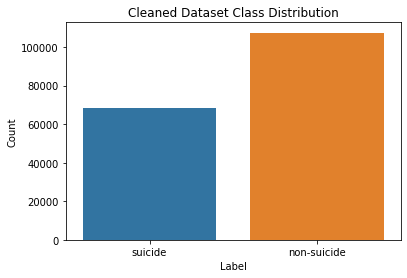

In [ ]:
# Check class distribution
print(clean_df['class'].value_counts())
print(clean_df['class'].value_counts(normalize=True))

sns.countplot(x=clean_df['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Train dataset

non-suicide    85948
suicide        54712
Name: class, dtype: int64
non-suicide    0.611034
suicide        0.388966
Name: class, dtype: float64


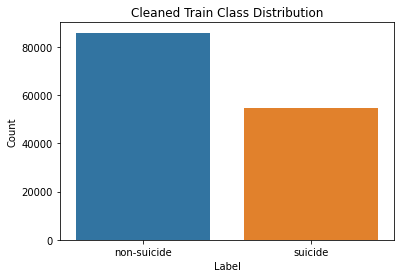

In [ ]:
# Check class distribution
print(train_data['class'].value_counts())
print(train_data['class'].value_counts(normalize=True))

sns.countplot(x=train_data['class'])
plt.title('Cleaned Train Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## Suicidal Text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_suicidal['cleaned_text'])

In [ ]:
tokenizer.word_counts.items()

odict_items([('wrong', 2053), ('head', 2341), ('dream', 1078), ('cut', 2556), ('wrist', 644), ('bathroom', 209), ('paint', 42), ('fault', 770), ('family', 6894), ('friend', 12266), ('mon', 2222), ('find', 5837), ('cold', 322), ('lifeless', 44), ('body', 1459), ('tile', 3), ('fantasize', 234), ('reaction', 115), ('care', 7758), ('mess', 855), ('create', 236), ('different', 1098), ('image', 110), ('scene', 46), ('slightly', 105), ('person', 4211), ('want', 41035), ('reality', 462), ('get', 9664), ('ready', 1730), ('kill', 14993), ('not', 110286), ('lock', 300), ('bondage', 8), ('handle', 1025), ('live', 12456), ('like', 24461), ('anymore', 12299), ('die', 14475), ('right', 6489), ('cop', 197), ('jail', 112), ('cell', 47), ('go', 20205), ('nim', 5), ('end', 12018), ('soon', 2609), ('possible', 777), ('trigger', 517), ('warn', 63), ('overdose', 1081), ('no', 20196), ('stick', 672), ('start', 3789), ('feel', 30596), ('awful', 631), ('try', 12907), ('long', 5793), ('burden', 1303), ('constan

In [ ]:
word_freq_suicidal = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

### Word Frequency Bar Graph

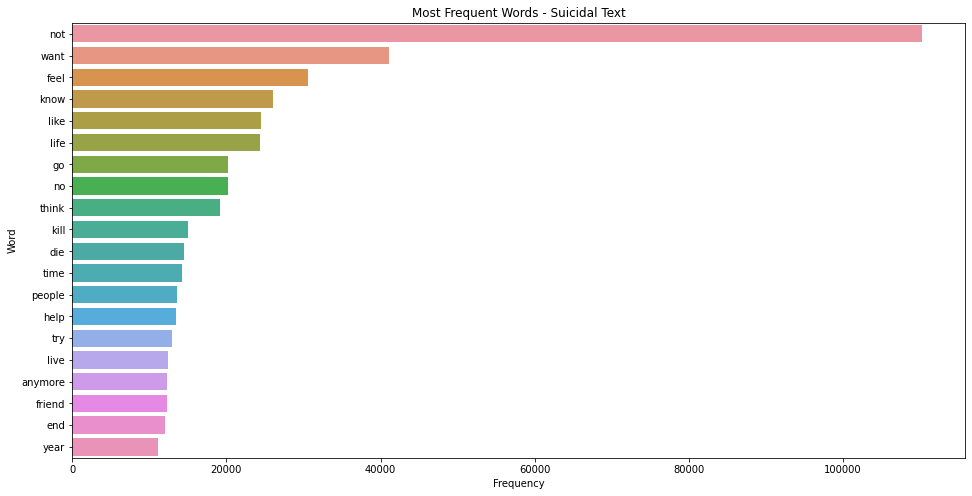

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

### Wordcloud

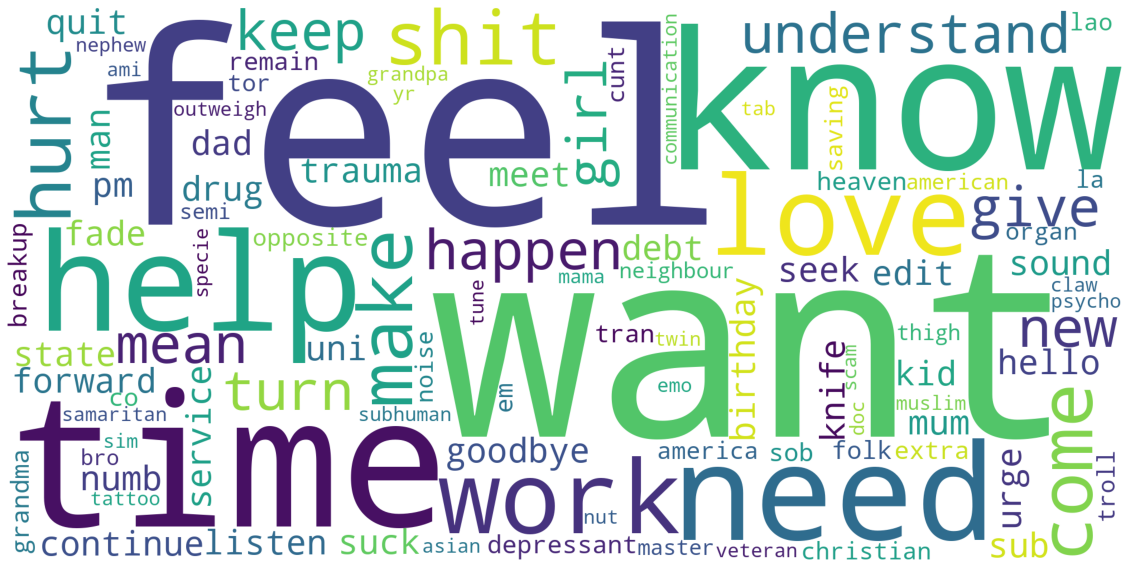

In [ ]:
# Wordcloud 
feature_names=word_freq_suicidal['word'].values
wc=WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

### Distribution of Text Length

In [ ]:
# Get average text length
train_data_suicidal['cleaned_text'] = train_data_suicidal['cleaned_text'].astype('str')
train_data_suicidal['length'] = train_data_suicidal['cleaned_text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


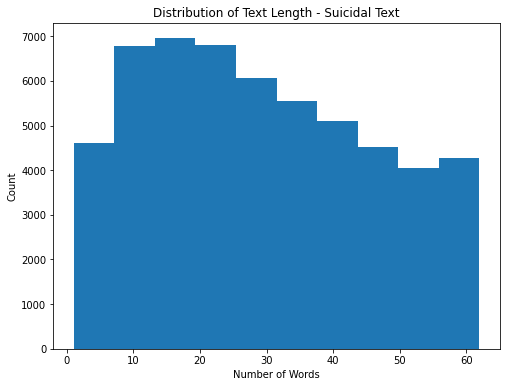

In [ ]:
# Plot average text length
ax = train_data_suicidal['length'].plot(kind='hist',title='Distribution of Text Length - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

### Polarity Score Distribution

In [ ]:
# Polarity score distribution
def get_polarity(text):
  return TextBlob(text).sentiment.polarity
train_data_suicidal['Polarity'] = train_data_suicidal['cleaned_text'].apply(get_polarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


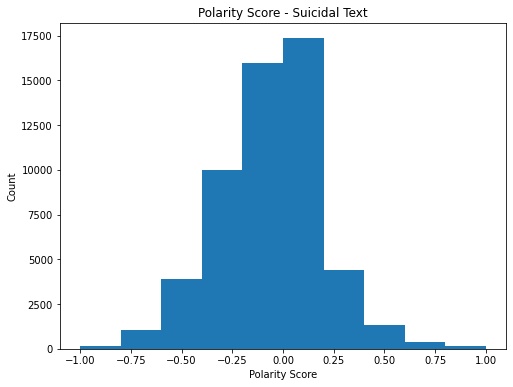

In [ ]:
# Plot polarity score graph
ax = train_data_suicidal['Polarity'].plot(kind='hist', title='Polarity Score - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

### Bigram

In [ ]:
!pip install nltk==3.6.2
#import nltk
#import sklearn

print('The nltk version is {}.'.format(nltk.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 10.1 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


The nltk version is 3.7.


In [ ]:
#Remove more stop words and do bigram
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_data_suicidal['without_stopwords'] = train_data_suicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_suicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

bigram_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Bigram,Count
0,"(feel, like)",10772
1,"(want, die)",5524
2,"(want, kill)",2382
3,"(want, end)",1944
4,"(commit, suicide)",1729
5,"(want, live)",1683
6,"(suicidal, thought)",1610
7,"(need, help)",1496
8,"(end, life)",1428
9,"(year, old)",1344


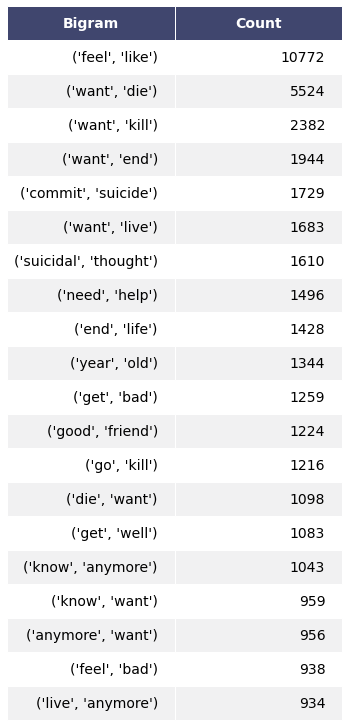

In [ ]:
#To make the table nicer
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(bigram_df, header_columns=0, col_width=3)

## Non-suicidal Text

In [ ]:
tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text"])

In [ ]:
tokenizer_nonsuicidal.word_counts.items()

odict_items([('how', 12285), ('do', 20738), ('people', 11055), ('with', 19013), ('no', 8401), ('legs', 201), ('pee', 201), ('they', 10857), ('get', 13090), ('up', 10353), ('there', 6240), ('anyone', 6922), ('wanna', 5352), ('join', 1324), ('a', 80851), ('discord', 1794), ('server', 1139), ('pm', 682), ('me', 38086), ('or', 15884), ('comment', 1661), ('if', 19451), ('you', 42140), ('i’m', 13901), ('murderer', 15), ('i', 149552), ('was', 18451), ('working', 619), ('in', 32728), ('the', 74954), ('garden', 40), ('today', 4360), ('and', 88038), ('saw', 1234), ('butterfly', 25), ('bouncing', 13), ('around', 2068), ('on', 23211), ('concrete', 23), ('walked', 235), ('over', 3199), ('to', 89786), ('it', 51567), ('noticed', 278), ('that', 30106), ('it’s', 6233), ('wing', 41), ('had', 6358), ('been', 6697), ('broken', 264), ('off', 3089), ('would', 7135), ('never', 4027), ('fly', 121), ('again', 2519), ('started', 2008), ('out', 11574), ('of', 38839), ('corner', 97), ('my', 56262), ('eye', 295), 

In [ ]:
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

,word,count
25,i,149552
41,to,89786
32,and,88038
14,a,80851
29,the,74954


### Word Frequency Bar Graph

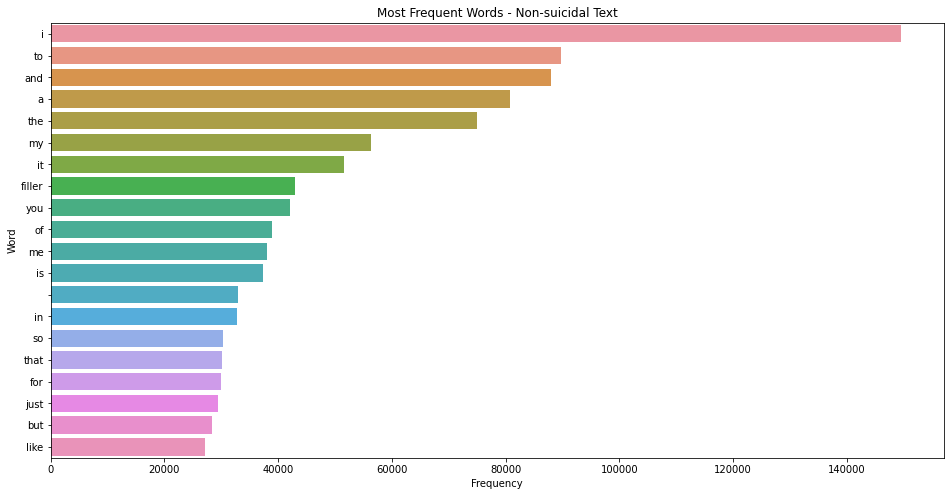

In [ ]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Non-suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

### Wordcloud

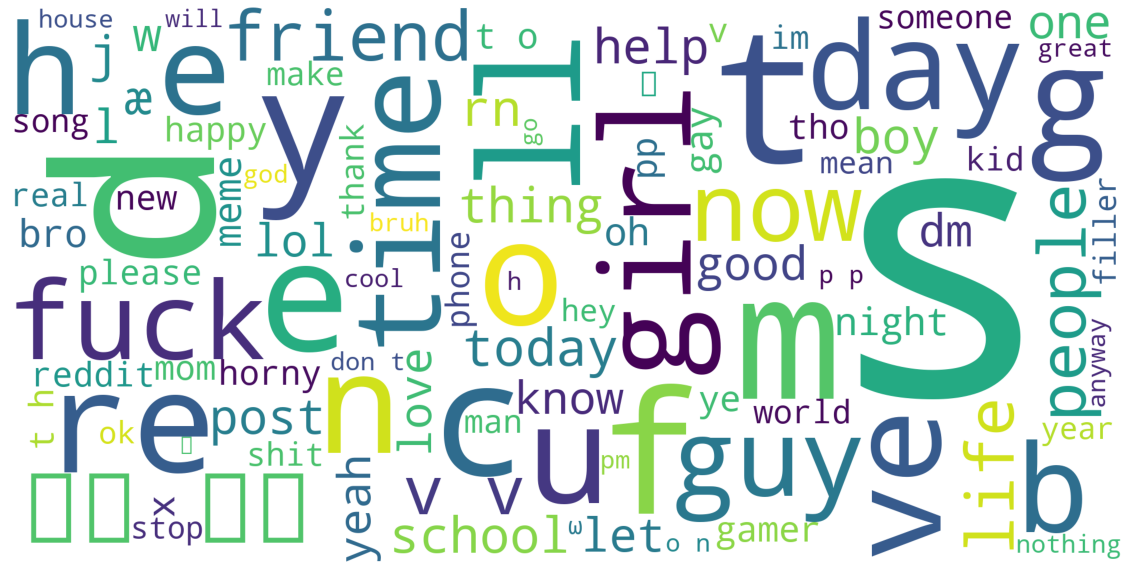

In [ ]:
# Wordcloud  
feature_names_nonsuicidal = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

### Distribution of Text Length

In [ ]:
# Get average text length
train_data_nonsuicidal['cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
train_data_nonsuicidal['length'] = train_data_nonsuicidal['cleaned_text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


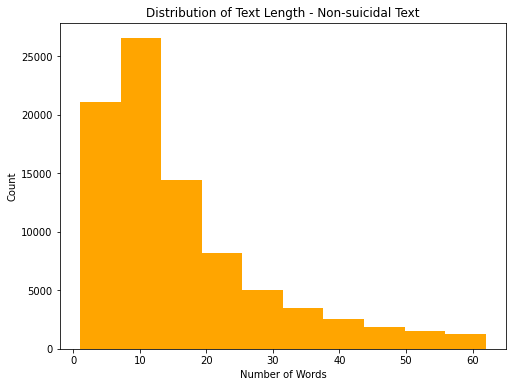

In [ ]:
# Plot distribution of text length
ax = train_data_nonsuicidal['length'].plot(kind='hist',title='Distribution of Text Length - Non-suicidal Text', color='orange', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

### Polarity Score Distribution

In [ ]:
# Polarity score distribution
train_data_nonsuicidal['cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
train_data_nonsuicidal['Polarity'] = train_data_nonsuicidal['cleaned_text'].apply(get_polarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


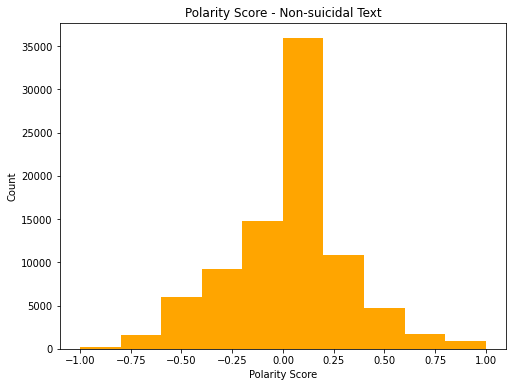

In [ ]:
# Plot polarity score graph
ax = train_data_nonsuicidal['Polarity'].plot(kind='hist', title='Polarity Score - Non-suicidal Text', color="orange", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

### Bigram

In [ ]:
#Remove more stop words and do bigram
stop_words = stopwords.words('english')
train_data_nonsuicidal['without_stopwords'] = train_data_nonsuicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_nonsuicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

render_mpl_table(bigram_df, header_columns=0, col_width=3)